[INFO] Loaded 3997 rows from 2010-01-05 to 2025-11-21
[INFO] Split sizes — train: 2383, val: 794, test: 795
[INFO] Fitting L1-logistic for C=0.01 ...
[INFO] Fitting L1-logistic for C=0.02 ...
[INFO] Fitting L1-logistic for C=0.05 ...
[INFO] Fitting L1-logistic for C=0.1 ...
[INFO] Fitting L1-logistic for C=0.25 ...
[INFO] Fitting L1-logistic for C=0.5 ...
[INFO] Fitting L1-logistic for C=1.0 ...
[INFO] Fitting L1-logistic for C=2.0 ...
[INFO] Fitting L1-logistic for C=5.0 ...
[INFO] Validation results (sorted by AUC):
      C   auc_val   acc_val  n_nonzero
8  5.00  0.515839  0.554156         10
7  2.00  0.515487  0.555416         10
6  1.00  0.515041  0.562972         10
5  0.50  0.513200  0.581864         10
3  0.10  0.507448  0.478589          4
2  0.05  0.502859  0.464736          2
4  0.25  0.502720  0.583123          9
0  0.01  0.500000  0.392947          0
1  0.02  0.500000  0.392947          0
[INFO] Best C=5.0 with val AUC=0.5158, acc=0.5542, non-zero=10
[INFO] Test metrics:
  

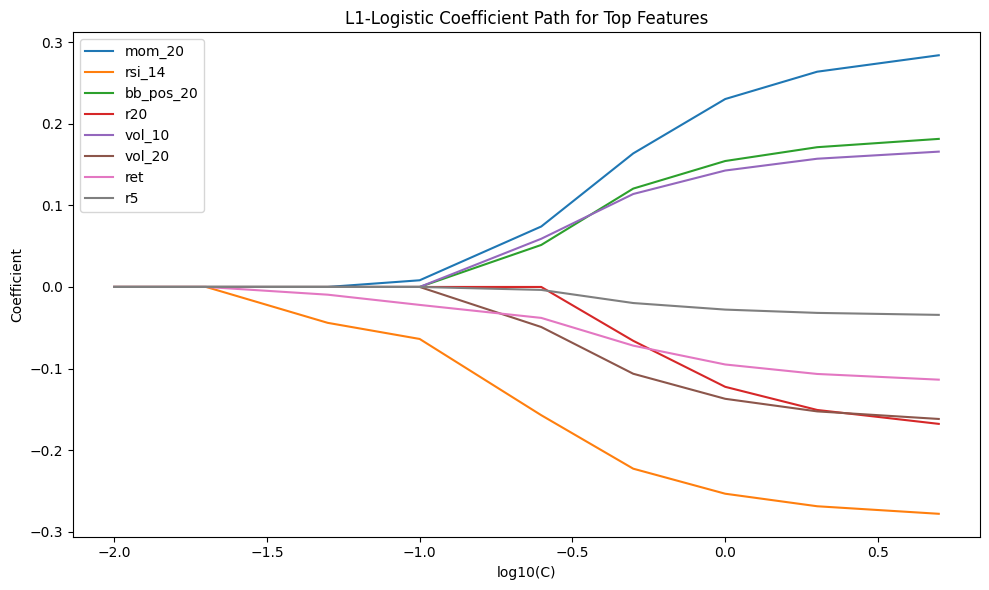

In [1]:
"""
Level-53 — L1-Logistic Regression Sparse Meta-Signal Engine
-----------------------------------------------------------

DSA concept (what you are practicing here)
------------------------------------------
This level is intentionally built around three core data-structures-and-algorithms ideas:

1) Sliding / rolling windows on arrays and time-series.
   You repeatedly slice time-indexed arrays (pandas Series/DataFrames) into
   train, validation, and test segments in chronological order. Conceptually,
   this is the same as using two pointers (start, end) that slide over an array.
   The feature engineering also uses rolling windows for moving averages and
   volatility, which is just a higher-level version of prefix sums and moving
   aggregates.

2) Matrix representations and sparsity.
   All features are ultimately converted into a 2D matrix X of shape (n_samples, n_features).
   L1-logistic regression pushes many coefficients exactly to zero, which is a
   sparse representation of the feature vector. Thinking in DSA terms, you can
   view the coefficient vector as a compressed data structure that only keeps
   "useful" dimensions and collapses the rest to zero.

3) Dictionaries and sorting for hyperparameter search.
   Hyperparameter tuning is implemented using nested loops over a grid of C
   (inverse regularization strength). For each C you store metrics and
   coefficient vectors in dictionaries keyed by the scalar C. Later, you turn
   that dictionary into a DataFrame and sort it by metrics (like AUC) to find
   the best configuration. That is a simple but powerful pattern:
       - loop over candidates,
       - accumulate stats in dicts,
       - sort / argmax at the end.

Quant idea (what this model does financially)
---------------------------------------------
This engine builds a directional classifier for a single asset (default SPY)
using daily data. It constructs features like short/long horizon returns,
rolling volatility, momentum, and an RSI-like oscillator. The target label is
the sign of a short-horizon forward return (for example, 5-day log return).

An L1-penalized logistic regression (saga solver) is used as the model. L1
regularization automatically performs feature selection by driving many
coefficients to exactly zero. You tune the regularization strength C over a
grid, using a chronological validation split to pick the value that yields the
best AUC. The final strategy goes long (1 unit) only when the predicted
probability of an up-move is above a threshold, otherwise it stays flat.
You then evaluate accuracy, AUC, Sharpe ratio, and hit-rate of this long/flat
strategy versus the underlying returns.

External resources (to study where similar ideas are used)
----------------------------------------------------------
For background on L1-logistic regression and how it is used for feature
selection and sparse classification, you can read the scikit-learn documentation
on logistic regression with L1 penalties:
    - scikit-learn LogisticRegression user guide and examples.

For a finance context, look at discussions of sparse logistic regression for
alpha factors and directional forecasting, for example in:
    - Quantitative trading / machine learning blogs that show "L1 logistic
      regression for stock direction prediction" or "sparse feature selection
      for equity alphas".
You can search these phrases along with "scikit-learn" to find real-world
notebooks and write-ups where similar models are applied to equity indices and
single-name stocks.

This script
-----------
1) Downloads daily prices via yfinance (with robust handling) and falls back to
   a synthetic geometric random walk if download fails.
2) Builds a small feature set: short/medium returns, volatility, momentum,
   Bollinger-band type information, and an RSI-like oscillator.
3) Builds a binary label using the sign of a k-day (configurable) forward return.
4) Performs a chronological split into train, validation, and test segments.
5) For each C in a grid, fits an L1-logistic regression (saga) on train,
   evaluates on validation, and records AUC, accuracy, and number of non-zero
   coefficients.
6) Selects the best C by validation AUC, refits on train+validation, and then
   evaluates on the test set.
7) Uses probability-threshold trading (long/flat) on the test set and computes
   Sharpe ratio and hit-rate.
8) Saves:
       - Per-date test predictions and strategy returns to CSV.
       - A coefficient path CSV for all C values.
       - A metrics JSON summarizing the best model and grid search results.
"""

from dataclasses import dataclass
from typing import Dict, List

import json
import math

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score


# ---------------------------- Config ---------------------------- #


@dataclass
class Config:
    symbol: str = "SPY"
    start: str = "2010-01-01"

    # labeling horizon in trading days
    label_horizon: int = 5

    # train/val/test fractions (chronological)
    train_frac: float = 0.6
    val_frac: float = 0.2  # test_frac = 1 - train_frac - val_frac

    # L1-logistic hyperparameter grid
    C_grid: List[float] = None  # will be filled in __post_init__
    max_iter: int = 400

    # trading rule
    proba_threshold: float = 0.55

    # output paths
    out_preds_csv: str = "level53_l1_logit_predictions.csv"
    out_coefs_csv: str = "level53_l1_logit_coef_path.csv"
    out_metrics_json: str = "level53_l1_logit_metrics.json"

    def __post_init__(self):
        if self.C_grid is None:
            # From strong regularization (sparse) to weak regularization (dense)
            self.C_grid = [0.01, 0.02, 0.05, 0.1, 0.25, 0.5, 1.0, 2.0, 5.0]


# ------------------------- Utility funcs ------------------------ #


def synthetic_price_series(
    n: int = 2500,
    start_price: float = 100.0,
) -> pd.Series:
    """Fallback geometric random walk if yfinance fails."""
    rng = np.random.default_rng(53)
    mu_daily = 0.06 / 252.0
    sigma_daily = 0.2 / math.sqrt(252.0)
    rets = rng.normal(mu_daily, sigma_daily, size=n)
    prices = start_price * np.exp(np.cumsum(rets))
    idx = pd.date_range("2010-01-01", periods=n, freq="B")
    return pd.Series(prices, index=idx, name="close")


def load_price_series(cfg: Config) -> pd.DataFrame:
    """
    Robust loader around yfinance.

    Handles:
        - Series
        - DataFrame with OHLCV
        - MultiIndex columns
    and falls back to synthetic data on error/empty.
    """
    try:
        px = yf.download(
            cfg.symbol,
            start=cfg.start,
            auto_adjust=True,
            progress=False,
        )
    except Exception:
        px = pd.DataFrame()

    if px is None or len(px) == 0:
        print("[WARN] yfinance download failed. Using synthetic price path.")
        close = synthetic_price_series()
    else:
        if isinstance(px, pd.Series):
            close_obj = px
        elif isinstance(px, pd.DataFrame):
            if "Close" in px.columns:
                close_obj = px["Close"]
            else:
                if isinstance(px.columns, pd.MultiIndex):
                    # Try to pick a ("Close", ticker) or similar
                    candidates = [
                        c
                        for c in px.columns
                        if str(c[0]).lower() == "close"
                        or str(c[-1]).lower() == "close"
                    ]
                    if len(candidates) > 0:
                        close_obj = px[candidates[0]]
                    else:
                        close_obj = px.iloc[:, 0]
                else:
                    # No "Close" column; pick first numeric
                    close_obj = px.select_dtypes(include=[np.number]).iloc[:, 0]
        else:
            raise RuntimeError("Unexpected type from yfinance download.")

        # Make sure we have a 1D array for the Series constructor
        close_arr = np.asarray(close_obj, dtype=float).reshape(-1)
        close = pd.Series(close_arr, index=close_obj.index, name="close")

    df = pd.DataFrame({"close": close.astype(float)})
    df["ret"] = np.log(df["close"]).diff()
    df = df.dropna().copy()
    return df


def sharpe_ratio(ret: pd.Series, ann_factor: float = 252.0) -> float:
    """Simple Sharpe estimate with ddof=1 for std."""
    if ret is None or len(ret) < 2:
        return 0.0
    mu = float(ret.mean())
    sigma = float(ret.std(ddof=1))
    if sigma <= 0:
        return 0.0
    return float(mu / sigma * math.sqrt(ann_factor))


def hit_rate(pred: pd.Series, realized: pd.Series) -> float:
    """
    Hit-rate between two return series:
    fraction of times sign(pred) == sign(realized) when both non-NaN.
    """
    aligned = pd.concat([pred, realized], axis=1).dropna()
    if aligned.shape[0] == 0:
        return 0.0
    correct = np.sign(aligned.iloc[:, 0]) == np.sign(aligned.iloc[:, 1])
    return float(correct.mean())


# ----------------------- Feature engineering -------------------- #


def build_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Feature set:

    r1, r5, r20:
        1, 5, 20 day log returns.
    vol_10, vol_20:
        rolling volatility of returns.
    mom_20:
        20-day log momentum.
    bb_pos_20:
        normalized position inside 20-day Bollinger band.
    rsi_14:
        RSI-like oscillator built from EWMA of up/down moves.
    """
    out = df.copy()

    out["r1"] = out["ret"].shift(1)
    out["r5"] = out["ret"].rolling(5).sum().shift(1)
    out["r20"] = out["ret"].rolling(20).sum().shift(1)

    out["vol_10"] = out["ret"].rolling(10).std().shift(1)
    out["vol_20"] = out["ret"].rolling(20).std().shift(1)

    out["mom_20"] = np.log(out["close"] / out["close"].shift(20))

    rolling_mean = out["close"].rolling(20).mean()
    rolling_std = out["close"].rolling(20).std()
    out["bb_pos_20"] = (out["close"] - rolling_mean) / (rolling_std + 1e-12)

    def rsi_like(ret: pd.Series, span: int = 14) -> pd.Series:
        up = ret.clip(lower=0.0)
        dn = -ret.clip(upper=0.0)
        avg_up = up.ewm(alpha=1 / span, adjust=False).mean()
        avg_dn = dn.ewm(alpha=1 / span, adjust=False).mean()
        rs = avg_up / (avg_dn + 1e-12)
        rsi = 100.0 - 100.0 / (1.0 + rs)
        return rsi

    out["rsi_14"] = rsi_like(out["ret"])

    out = out.dropna().copy()
    return out


def build_labels(feat_df: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    Forward return label:
        fut_ret = log(close_{t+h} / close_t)
        y = 1 if fut_ret > 0 else 0
    """
    fut_ret = np.log(feat_df["close"].shift(-horizon) / feat_df["close"])
    y = (fut_ret > 0.0).astype(int)
    return pd.DataFrame({"fut_ret": fut_ret, "y": y})


# ---------------------- Time splits & model --------------------- #


def chrono_splits(
    data: pd.DataFrame,
    train_frac: float,
    val_frac: float,
) -> Dict[str, pd.DataFrame]:
    """
    Chronological splits: train, val, test.

    Lengths:
        n_train = floor(train_frac * n)
        n_val   = floor(val_frac * n)
        n_test  = n - n_train - n_val
    """
    n = len(data)
    n_train = int(train_frac * n)
    n_val = int(val_frac * n)
    n_test = n - n_train - n_val
    if n_test <= 0:
        raise ValueError("Not enough data for test split; adjust fractions.")

    train = data.iloc[:n_train].copy()
    val = data.iloc[n_train : n_train + n_val].copy()
    test = data.iloc[n_train + n_val :].copy()

    return {"train": train, "val": val, "test": test}


def fit_l1_logit_for_C(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    y_val: pd.Series,
    C: float,
    cfg: Config,
) -> Dict[str, float]:
    """
    Fit a StandardScaler + L1-logistic pipeline for a given C,
    and evaluate metrics on the validation set.
    """
    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(
                    penalty="l1",
                    C=C,
                    solver="saga",
                    max_iter=cfg.max_iter,
                    random_state=53,
                    class_weight="balanced",
                    n_jobs=-1,
                ),
            ),
        ]
    )

    pipe.fit(X_train.values, y_train.values)
    proba_val = pipe.predict_proba(X_val.values)[:, 1]
    y_pred_val = (proba_val >= 0.5).astype(int)

    try:
        auc_val = roc_auc_score(y_val.values, proba_val)
    except ValueError:
        auc_val = float("nan")

    acc_val = accuracy_score(y_val.values, y_pred_val)

    # Extract coefficients: pipe['clf'].coef_ is (1, n_features)
    coef = pipe.named_steps["clf"].coef_.ravel()
    n_nonzero = int(np.sum(np.abs(coef) > 1e-8))

    return {
        "C": float(C),
        "auc_val": float(auc_val) if np.isfinite(auc_val) else float("nan"),
        "acc_val": float(acc_val),
        "n_nonzero": n_nonzero,
        "coef": coef,
        "pipe": pipe,
    }


def refit_best_model(
    data_split: Dict[str, pd.DataFrame],
    X_cols: List[str],
    C_best: float,
    cfg: Config,
) -> Pipeline:
    """
    Refit L1-logistic on train+val with the chosen best C,
    return the fitted pipeline.
    """
    train = data_split["train"]
    val = data_split["val"]
    df_tv = pd.concat([train, val], axis=0)

    X_tv = df_tv[X_cols]
    y_tv = df_tv["y"].astype(int)

    pipe = Pipeline(
        [
            ("scaler", StandardScaler()),
            (
                "clf",
                LogisticRegression(
                    penalty="l1",
                    C=C_best,
                    solver="saga",
                    max_iter=cfg.max_iter,
                    random_state=53,
                    class_weight="balanced",
                    n_jobs=-1,
                ),
            ),
        ]
    )
    pipe.fit(X_tv.values, y_tv.values)
    return pipe


# ----------------------------- IO ------------------------------- #


def save_predictions(
    test_df: pd.DataFrame,
    proba: pd.Series,
    strat_ret: pd.Series,
    cfg: Config,
) -> None:
    out = pd.DataFrame(
        {
            "close": test_df["close"],
            "ret": test_df["ret"],
            "p_up": proba,
            "strat_ret": strat_ret,
            "label_y": test_df["y"],
            "fut_ret": test_df["fut_ret"],
        }
    )
    out.to_csv(cfg.out_preds_csv, index=True)
    print(f"[OK] Saved test predictions → {cfg.out_preds_csv}")


def save_coef_path(
    C_grid: List[float],
    coef_dict: Dict[float, np.ndarray],
    feature_names: List[str],
    cfg: Config,
) -> None:
    """
    Save coefficient paths for all C values as a CSV with
    rows = features, columns = C values.
    """
    rows = []
    for feat_idx, feat in enumerate(feature_names):
        row = {"feature": feat}
        for C in C_grid:
            coef_vec = coef_dict.get(C)
            if coef_vec is not None and feat_idx < len(coef_vec):
                row[f"C={C}"] = float(coef_vec[feat_idx])
            else:
                row[f"C={C}"] = float("nan")
        rows.append(row)

    df_coef = pd.DataFrame(rows)
    df_coef.to_csv(cfg.out_coefs_csv, index=False)
    print(f"[OK] Saved coefficient path → {cfg.out_coefs_csv}")


def save_metrics(
    best_result: Dict[str, float],
    grid_metrics: pd.DataFrame,
    test_metrics: Dict[str, float],
    cfg: Config,
) -> None:
    payload = {
        "best_C": best_result["C"],
        "best_val_auc": best_result["auc_val"],
        "best_val_acc": best_result["acc_val"],
        "best_n_nonzero": best_result["n_nonzero"],
        "test_metrics": test_metrics,
        "grid_metrics": grid_metrics.to_dict(orient="records"),
    }
    with open(cfg.out_metrics_json, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2)
    print(f"[OK] Saved metrics → {cfg.out_metrics_json}")


def plot_coef_path(
    C_grid: List[float],
    coef_dict: Dict[float, np.ndarray],
    feature_names: List[str],
    top_k: int = 8,
) -> None:
    """
    One simple plot: for top_k features (by max |coef| across C),
    plot coefficient vs log10(C).
    """
    # Build matrix of shape (n_features, n_C)
    Cs = sorted(C_grid)
    mat = np.vstack([coef_dict[C] for C in Cs])
    # mat shape: (n_C, n_features). Transpose to (n_features, n_C)
    mat = mat.T
    max_abs = np.max(np.abs(mat), axis=1)
    idx_sorted = np.argsort(-max_abs)
    top_idx = idx_sorted[:top_k]

    plt.figure(figsize=(10, 6))
    for i in top_idx:
        plt.plot(
            np.log10(Cs),
            mat[i, :],
            label=feature_names[i],
        )
    plt.xlabel("log10(C)")
    plt.ylabel("Coefficient")
    plt.title("L1-Logistic Coefficient Path for Top Features")
    plt.legend()
    plt.tight_layout()
    plt.show()


# --------------------------- Pipeline --------------------------- #


def run_pipeline(cfg: Config) -> None:
    # 1) Load prices
    df = load_price_series(cfg)
    print(
        f"[INFO] Loaded {len(df)} rows from {df.index.min().date()} "
        f"to {df.index.max().date()}"
    )

    # 2) Features and labels
    feat = build_features(df)
    lab = build_labels(feat, cfg.label_horizon)

    data = pd.concat([feat, lab], axis=1).dropna().copy()

    # 3) Chronological splits
    splits = chrono_splits(data, cfg.train_frac, cfg.val_frac)
    train = splits["train"]
    val = splits["val"]
    test = splits["test"]

    X_cols = [c for c in data.columns if c not in ("y", "fut_ret")]

    X_train = train[X_cols]
    y_train = train["y"].astype(int)
    X_val = val[X_cols]
    y_val = val["y"].astype(int)
    X_test = test[X_cols]
    y_test = test["y"].astype(int)

    print(
        f"[INFO] Split sizes — "
        f"train: {len(train)}, val: {len(val)}, test: {len(test)}"
    )

    # 4) Hyperparameter search across C_grid
    results = []
    coef_dict: Dict[float, np.ndarray] = {}
    pipe_dict: Dict[float, Pipeline] = {}

    for C in cfg.C_grid:
        print(f"[INFO] Fitting L1-logistic for C={C} ...")
        res = fit_l1_logit_for_C(
            X_train,
            y_train,
            X_val,
            y_val,
            C,
            cfg,
        )
        results.append(
            {
                "C": res["C"],
                "auc_val": res["auc_val"],
                "acc_val": res["acc_val"],
                "n_nonzero": res["n_nonzero"],
            }
        )
        coef_dict[C] = res["coef"]
        pipe_dict[C] = res["pipe"]

    grid_df = pd.DataFrame(results).sort_values("auc_val", ascending=False)
    print("[INFO] Validation results (sorted by AUC):")
    print(grid_df)

    # 5) Choose best C by validation AUC
    best_row = grid_df.iloc[0].to_dict()
    C_best = float(best_row["C"])
    print(
        f"[INFO] Best C={C_best} with val AUC="
        f"{best_row['auc_val']:.4f}, acc={best_row['acc_val']:.4f}, "
        f"non-zero={int(best_row['n_nonzero'])}"
    )

    # 6) Refit on train+val with best C
    best_pipe = refit_best_model(splits, X_cols, C_best, cfg)

    # 7) Evaluate on test set
    p_up_test = pd.Series(
        best_pipe.predict_proba(X_test.values)[:, 1],
        index=X_test.index,
        name="p_up",
    )
    y_pred_test = (p_up_test >= 0.5).astype(int)

    try:
        auc_test = roc_auc_score(y_test.values, p_up_test.values)
    except ValueError:
        auc_test = float("nan")

    acc_test = accuracy_score(y_test.values, y_pred_test.values)

    # Strategy: long if p_up >= threshold, flat otherwise
    strat_ret = pd.Series(0.0, index=X_test.index, name="strat_ret")
    mask_long = p_up_test >= cfg.proba_threshold
    strat_ret.loc[mask_long] = df["ret"].loc[strat_ret.index][mask_long]

    sharpe_strat = sharpe_ratio(strat_ret)
    hit_strat = hit_rate(strat_ret, df["ret"].loc[strat_ret.index])

    test_metrics = {
        "auc_test": float(auc_test) if np.isfinite(auc_test) else float("nan"),
        "acc_test": float(acc_test),
        "sharpe_strat": float(sharpe_strat),
        "hit_rate_strat_vs_ret": float(hit_strat),
        "proba_threshold": float(cfg.proba_threshold),
        "n_test": int(len(test)),
    }

    print("[INFO] Test metrics:")
    for k, v in test_metrics.items():
        print(f"  {k}: {v}")

    # 8) Save outputs
    save_predictions(test, p_up_test, strat_ret, cfg)
    save_coef_path(cfg.C_grid, coef_dict, X_cols, cfg)
    save_metrics(best_row, grid_df, test_metrics, cfg)

    # 9) Optional coefficient-path plot
    try:
        plot_coef_path(cfg.C_grid, coef_dict, X_cols, top_k=8)
    except Exception:
        pass


# ----------------------------- Main ----------------------------- #


if __name__ == "__main__":
    # Make it Jupyter-safe by stripping unwanted CLI args
    import sys

    sys.argv = [sys.argv[0]]
    cfg = Config()
    run_pipeline(cfg)
